## 3D Volume-to-Volume Translation with Conditional Adversarial Networks (GAN's)
import all necessary libs and frameworks

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
from skimage import io
from skimage.filters import gaussian
import itertools
from datetime import datetime
import json
import cv2
from IPython.display import clear_output

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%load_ext autoreload
%autoreload 2

sys.path.insert(0, './scripts')

import helper as hp
import data_loader3D as dl
import deconvolution as deconv
import vol2vol as v2v
import plot3DVol as plot3D

from NanoImagingPack.microscopy import PSF3D
from NanoImagingPack.view import view

Using TensorFlow backend.


In [3]:
import warnings
warnings.filterwarnings("ignore")

### look for the data

In [4]:
dataset_name = 'VascuSynth'

path = glob('./data/3D/{0}/train/*'.format(dataset_name))
path = [item for item in path if item.endswith('.tif') or item.endswith('.tiff')]

dl.print_volume_dimension(path, max_print=5)

dimensions of volumes:
0 (101, 101, 101)
1 (101, 101, 101)
2 (101, 101, 101)
3 (101, 101, 101)
4 (101, 101, 101)


### plot the distribution of a random image and the result after histogram equalization

(101, 101) 0.0 0.8742492782842862 (10201,)
unique bins of gray values of original volume:			 1503
unique bins of gray values after histogram eqaulization:	 981


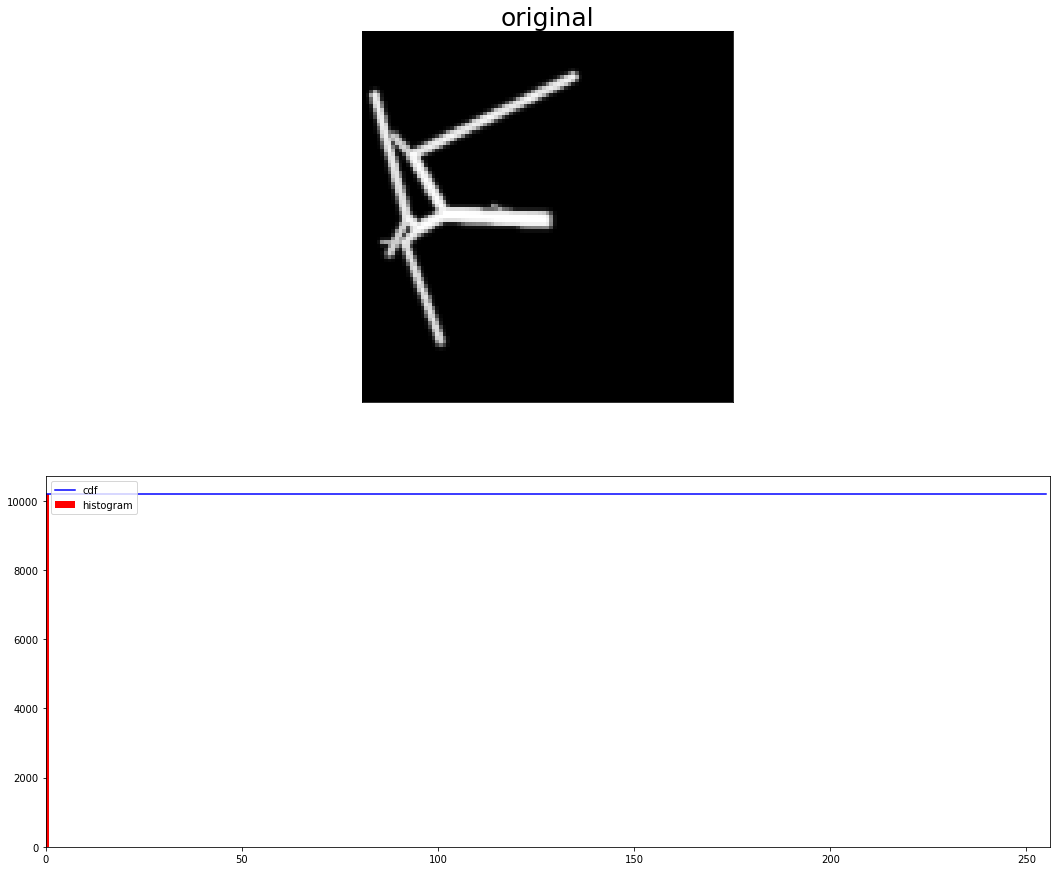

In [5]:
from skimage import exposure

vol = io.imread(np.random.choice(path, size=1)[0])
vol = gaussian(vol, sigma=0.5)
img = np.max(vol, axis=2)#/127.5-1
print(img.shape, np.min(img), np.max(img), img.flatten().shape)

print('unique bins of gray values of original volume:\t\t\t', len(np.unique(img)))

hist,bins = np.histogram(img.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

# p2, p98 = np.percentile(img, (2, 98))
# print(p2, p98)
# equ = exposure.rescale_intensity(img, in_range='image', out_range=(p2, p98))
equ = exposure.equalize_adapthist(img, clip_limit=0.02)
# equ = exposure.equalize_hist(img)
print('unique bins of gray values after histogram eqaulization:\t', len(np.unique(equ)))
# print(np.unique(equ))

fig = plt.figure(figsize=(18, 15))
plt.subplot(211); 
plt.imshow(img, cmap='gray'); plt.xticks([]); plt.yticks([]); plt.title('original', fontsize=25)
plt.subplot(212);
plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')

# plt.subplot(223);
# plt.imshow(equ, cmap='gray'); plt.xticks([]); plt.yticks([]); plt.title('equalized', fontsize=25)
# hist_eq,bins_eq = np.histogram(img.flatten(),256,[0,256])
# cdf = hist.cumsum()
# cdf_normalized = cdf * hist.max()/ cdf.max()
# plt.subplot(224);
# plt.plot(cdf_normalized, color = 'b')
# plt.hist(equ.flatten())#,256,[0,256], color = 'r')
# plt.xlim([0,256])
# plt.legend(('cdf','histogram'), loc = 'upper left')

plt.show()

from skimage import data, img_as_float
from skimage import exposure
import cv2

# create a CLAHE object (Arguments are optional).
# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
# cl1 = clahe.apply(img)

# res = np.hstack((img,cl1)) #stacking images side-by-side
# plt.imshow(res)

### create TFRecord file

In [6]:
vol_orginal_size = (101,101,101) 
vol_resize_size = (64,64,64)

with open('./scripts/config.json') as json_data:
    otf_info = json.load(json_data)['OTF']

data_loader = dl.DataLoader3D(micro_noise=10000, 
                              d_name=dataset_name, 
                              manipulation='NONE', 
                              vol_original=vol_orginal_size,
                              vol_resize=vol_resize_size,
                              otf=otf_info,
                              augm_factor=0)

filename = './data/TFRecords/{0}_train.tfrecords'.format(dataset_name)

# data_loader.writeTFRecord(filename)

### test the 3D psf for a random volume

8 [0.         0.12156863 0.24705882 0.37254902 0.49803922 0.62352941
 0.74901961 0.8745098 ]
43979 [0.00000000e+00 2.23340398e-12 4.46680795e-12 4.53885324e-12
 6.77225722e-12 6.84430251e-12 9.14975177e-12 1.13831557e-11
 1.14552010e-11 1.36886050e-11]
image before cut/resize in x/y dimension:	 (101, 101, 101)
image after cut/resize in x/y dimension:	 (64, 64, 64)


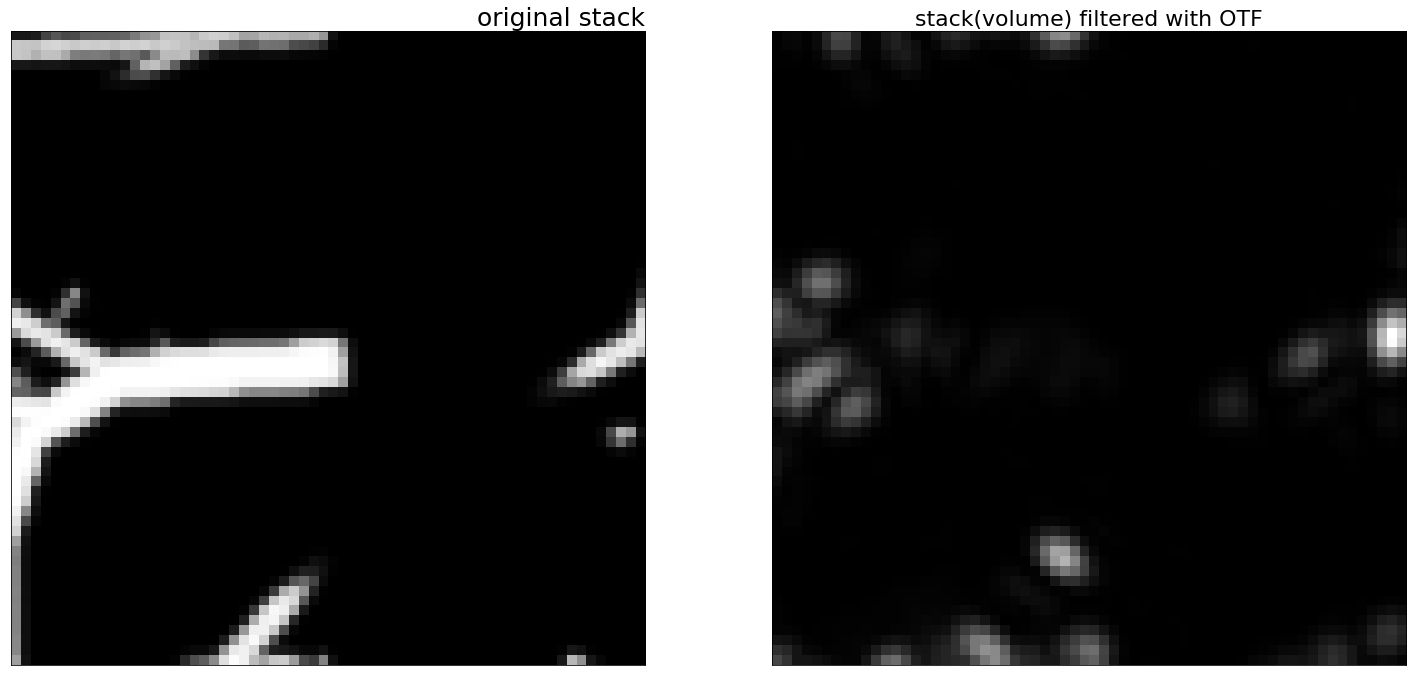

Wall time: 2.86 s


In [7]:
%%time 

sample = np.random.choice(path, size=1)[0]

vol = io.imread(sample)/255.
print(len(np.unique(vol)), np.unique(vol)[:10])
vol = gaussian(vol, sigma=0.5)
print(len(np.unique(vol)), np.unique(vol)[:10])
print('image before cut/resize in x/y dimension:\t', vol.shape)

# compute OTF
otf = PSF3D(im=vol.shape, ret_val = 'OTF')

# perform convolution on stack with computed otf (with numpy) and add noise
vol_otf = deconv.conv3d_fft(vol, otf)
vol_otf = data_loader.put_noise(vol_otf)

vol = data_loader.cut_volume(vol, vol_resize_size, centered=True)
vol_otf = data_loader.cut_volume(vol_otf, vol_resize_size, centered=True)
print('image after cut/resize in x/y dimension:\t', vol.shape)

f = plt.figure(figsize=(25,15))
plt.subplot(121); 
temp = plt.imshow(np.max(vol, axis=2), cmap='gray');
plt.xticks([]); plt.yticks([]); plt.title('original stack', fontsize=25, loc='right')
plt.subplot(122); 
temp = plt.imshow(np.max(vol_otf, axis=2), cmap='gray');
plt.xticks([]); plt.yticks([]); plt.title('stack(volume) filtered with OTF', fontsize=22)
plt.show()

### plot entire volume and default PSF

In [8]:
#%matplotlib notebook

# dub_path = '../data/3D/dub/dub01.tif'
# dub = io.imread(dub_path)
# print(dub.shape)
# dub = hp.swapAxes(dub, swap=True)
# print(dub.shape)

# vol_3D = plot3D.Interactive_3DVolume(vol=dub)
# vol_3D.multi_slice_viewer()

# Christians tool 
# v = view(dub, show_hist=False)

### and initialize the volume to volume GAN

First we have a look for network-configuration.<br>
**Important configurations are:**
- manipulation of the stack axes (MANIPULATION_STACKS) -> influence on the quality of the image
- using GANHACK -> techniques for improve GAN training
- the NETWORK_DEPTH -> the depth has a large impact on the duration of the GAN-training
- learning-rate of the optimizer

In [9]:
import json 
import pprint

with open('./scripts/config.json') as json_data:
    json_file = json.load(json_data)
    selected = json_file['selected']
    pprint.pprint(selected)

{'ADAM_OPTIMIZER_LEARNRATE': 7e-05,
 'BATCH_NORMALIZATION': True,
 'BATCH_SIZE': 2,
 'COMBINED_LOSS': ['mse', 'mae'],
 'DATASET_NAME': 'VascuSynth',
 'DATA_AUGMENTATION_FACTOR': 2,
 'DROPOUT': 0.03,
 'D_LOSS': 'mse',
 'FLIP_LABEL_PROB': 0.03,
 'GANHACKS': False,
 'GAUSSIAN_NOISE_TO_G': 0.03,
 'INCREASE_LOSS_WEIGHTS': 1.1,
 'INSTANCE_NOISE': False,
 'LOSS_WEIGHTS': [1, 100],
 'MANIPULATION_STACKS': 'NONE',
 'MICRO_NOISE_NPhot': 1000,
 'NETWORK_DEPTH': 'HIGH',
 'NUMBER_ONLY_TRAIN_G': 1,
 'ONE-SIDED-LABEL': 1.1,
 'POOLING': 'AVERAGE',
 'RESIZE': {'depth': 32, 'height': 64, 'width': 64},
 'SAVE_LOGS': False,
 'SAVE_MODEL': False,
 'SAVE_TABLE_IMAGES': True,
 'SAVE_VOLUME': False}


In [10]:
vol_orginal_size = (101,101,101)
print('volume orginial size:\t\t', vol_orginal_size)
print('volume cut (resize):\t\t', selected['RESIZE'])
print('dataset name:\t\t\t', selected['DATASET_NAME'])

grid_search = json_file['grid_search']
keys, values = zip(*grid_search.items())
experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

print('number of all hyper parameter combinations:\t', len(experiments))

volume orginial size:		 (101, 101, 101)
volume cut (resize):		 {'width': 64, 'height': 64, 'depth': 32}
dataset name:			 VascuSynth
number of all hyper parameter combinations:	 3


### create gan object and train the GAN

dependent for a grid search

In [11]:
# release GPU

from keras import backend as K
import gc

def clear_models_session():    
    try:
        del gan, discriminator, combined, generator 
    except:
        pass
#         print('models not available')
    K.clear_session()
    gc.collect()
        
clear_models_session()

In [ ]:
%%time

gridSearch = False
epochs, s_interval = 150, 22 

if gridSearch:
    for hyper_parameter in experiments:
        selected.update(hyper_parameter)
        clear_output()
#         pprint.pprint(selected)
        print('---------------------------------------------------------')
               
        try:
            gan = v2v.Pix3Pix(vol_original=vol_orginal_size, grid_search=gridSearch, parameter=selected)
            gan.train(epochs=epochs, sample_interval=s_interval)
            clear_models_session()
        except:
            clear_models_session()
            continue
else:
    clear_models_session()
    
    gan = v2v.Pix3Pix(vol_original=vol_orginal_size, grid_search=gridSearch)
    gan.train(epochs=epochs, sample_interval=s_interval)

discriminator-model in/output:	 (?, 64, 64, 32, 1) (?, 64, 64, 32, 1) 
				 (?, 4, 4, 2, 1)
generator-model input:		 (?, 64, 64, 32, 1)
downsampling:			 (?, 32, 32, 16, 64)
downsampling:			 (?, 16, 16, 8, 128)
downsampling:			 (?, 8, 8, 4, 256)
downsampling:			 (?, 4, 4, 2, 512)
downsampling:			 (?, 2, 2, 1, 512)
downsampling:			 (?, 1, 1, 1, 512)
upsampling:			 (?, 2, 2, 1, 512)
upsampling:			 (?, 4, 4, 2, 512)
upsampling:			 (?, 8, 8, 4, 256)
upsampling:			 (?, 16, 16, 8, 128)
upsampling:			 (?, 32, 32, 16, 64)
generator-model output:		 (?, 64, 64, 32, 1)
finish Pix3Pix __init__

[Epoch 0/149][Batch 0/53] [D loss: ----, acc: ----] [G loss: 93.190353] t: 0:00:20.360578 False A
[Epoch 0/149][Batch 0/53] [D loss: ----, acc: ----] [G loss: 89.363327] t: 0:00:21.498724 False
[Epoch 0/149][Batch 1/53] [D loss: ----, acc: ----] [G loss: 75.127289] t: 0:00:36.157453 False A
[Epoch 0/149][Batch 1/53] [D loss: ----, acc: ----] [G loss: 59.651646] t: 0:00:36.476011 False
[Epoch 0/149][Batch 2/5

[Epoch 0/149][Batch 39/53] [D loss: ----, acc: ----] [G loss: 5.121428] t: 0:05:43.813453 False
[Epoch 0/149][Batch 40/53] [D loss: ----, acc: ----] [G loss: 4.420656] t: 0:05:51.166733 False A
[Epoch 0/149][Batch 40/53] [D loss: ----, acc: ----] [G loss: 4.960569] t: 0:05:51.485728 False
[Epoch 0/149][Batch 41/53] [D loss: ----, acc: ----] [G loss: 4.633902] t: 0:05:59.073167 False A
[Epoch 0/149][Batch 41/53] [D loss: ----, acc: ----] [G loss: 4.782566] t: 0:05:59.375662 False
[Epoch 0/149][Batch 42/53] [D loss: ----, acc: ----] [G loss: 3.826520] t: 0:06:06.916785 False A
[Epoch 0/149][Batch 42/53] [D loss: ----, acc: ----] [G loss: 3.960436] t: 0:06:07.232028 False
[Epoch 0/149][Batch 43/53] [D loss: ----, acc: ----] [G loss: 3.725262] t: 0:06:14.539409 False A
[Epoch 0/149][Batch 43/53] [D loss: ----, acc: ----] [G loss: 3.955083] t: 0:06:14.854449 False
[Epoch 0/149][Batch 44/53] [D loss: ----, acc: ----] [G loss: 3.802986] t: 0:06:22.045903 False A
[Epoch 0/149][Batch 44/53] [D 

[Epoch 1/149][Batch 28/53] [D loss: 0.543882, acc:  50%] [G loss: 2.185909] t: 0:11:38.809695 False A
[Epoch 1/149][Batch 28/53] [D loss: 0.469933, acc:  59%] [G loss: 2.337374] t: 0:11:39.131939 False
[Epoch 1/149][Batch 29/53] [D loss: 0.599397, acc:  49%] [G loss: 2.298834] t: 0:11:47.117658 False A
[Epoch 1/149][Batch 29/53] [D loss: 0.275792, acc:  66%] [G loss: 2.744647] t: 0:11:47.440226 False
[Epoch 1/149][Batch 30/53] [D loss: 0.523608, acc:  50%] [G loss: 2.351664] t: 0:11:55.616156 False A
[Epoch 1/149][Batch 30/53] [D loss: 0.314400, acc:  63%] [G loss: 2.442033] t: 0:11:55.938607 False
[Epoch 1/149][Batch 31/53] [D loss: 0.384710, acc:  59%] [G loss: 2.536917] t: 0:12:04.105914 False A
[Epoch 1/149][Batch 31/53] [D loss: 0.458644, acc:  50%] [G loss: 2.519107] t: 0:12:04.432409 False
[Epoch 1/149][Batch 32/53] [D loss: 0.506127, acc:  50%] [G loss: 1.890108] t: 0:12:12.424920 False A
[Epoch 1/149][Batch 32/53] [D loss: 0.384649, acc:  58%] [G loss: 2.636407] t: 0:12:12.746

[Epoch 2/149][Batch 16/53] [D loss: 0.144637, acc:  83%] [G loss: 1.833866] t: 0:17:25.669791 False A
[Epoch 2/149][Batch 16/53] [D loss: 0.151419, acc:  80%] [G loss: 2.434557] t: 0:17:25.987628 False
[Epoch 2/149][Batch 17/53] [D loss: 0.163605, acc:  81%] [G loss: 2.536330] t: 0:17:33.372046 False A
[Epoch 2/149][Batch 17/53] [D loss: 0.123644, acc:  87%] [G loss: 2.609250] t: 0:17:33.683142 False
[Epoch 2/149][Batch 18/53] [D loss: 0.127899, acc:  84%] [G loss: 2.844539] t: 0:17:41.059773 False A
[Epoch 2/149][Batch 18/53] [D loss: 0.097660, acc:  89%] [G loss: 2.974894] t: 0:17:41.377175 False
[Epoch 2/149][Batch 19/53] [D loss: 0.255098, acc:  64%] [G loss: 1.423291] t: 0:17:48.825137 False A
[Epoch 2/149][Batch 19/53] [D loss: 0.122593, acc:  83%] [G loss: 2.099002] t: 0:17:49.142080 False
[Epoch 2/149][Batch 20/53] [D loss: 0.162018, acc:  80%] [G loss: 2.215933] t: 0:17:56.528159 False A
[Epoch 2/149][Batch 20/53] [D loss: 0.152688, acc:  78%] [G loss: 2.701390] t: 0:17:56.845

[Epoch 3/149][Batch 4/53] [D loss: 0.104093, acc:  87%] [G loss: 2.122501] t: 0:22:53.156910 False A
[Epoch 3/149][Batch 4/53] [D loss: 0.122665, acc:  82%] [G loss: 2.550475] t: 0:22:53.471668 False
[Epoch 3/149][Batch 5/53] [D loss: 0.114419, acc:  88%] [G loss: 2.074400] t: 0:23:01.066056 False A
[Epoch 3/149][Batch 5/53] [D loss: 0.099376, acc:  85%] [G loss: 2.363119] t: 0:23:01.380811 False
[Epoch 3/149][Batch 6/53] [D loss: 0.163320, acc:  76%] [G loss: 1.092263] t: 0:23:08.804514 False A
[Epoch 3/149][Batch 6/53] [D loss: 0.107514, acc:  91%] [G loss: 1.881788] t: 0:23:09.122153 False
[Epoch 3/149][Batch 7/53] [D loss: 0.072020, acc:  92%] [G loss: 1.939234] t: 0:23:16.966855 False A
[Epoch 3/149][Batch 7/53] [D loss: 0.102574, acc:  87%] [G loss: 2.290143] t: 0:23:17.277912 False
[Epoch 3/149][Batch 8/53] [D loss: 0.149822, acc:  78%] [G loss: 1.330645] t: 0:23:24.933667 False A
[Epoch 3/149][Batch 8/53] [D loss: 0.096413, acc:  89%] [G loss: 2.127523] t: 0:23:25.249089 False


[Epoch 3/149][Batch 45/53] [D loss: 0.084875, acc:  88%] [G loss: 2.369114] t: 0:28:24.890899 False A
[Epoch 3/149][Batch 45/53] [D loss: 0.063575, acc:  95%] [G loss: 2.312528] t: 0:28:25.215397 False
[Epoch 3/149][Batch 46/53] [D loss: 0.119820, acc:  86%] [G loss: 2.448940] t: 0:28:33.096000 False A
[Epoch 3/149][Batch 46/53] [D loss: 0.075251, acc:  94%] [G loss: 2.487981] t: 0:28:33.419290 False
[Epoch 3/149][Batch 47/53] [D loss: 0.325285, acc:  50%] [G loss: 3.763795] t: 0:28:41.078461 False A
[Epoch 3/149][Batch 47/53] [D loss: 0.504619, acc:  47%] [G loss: 4.002505] t: 0:28:41.391066 False
[Epoch 3/149][Batch 48/53] [D loss: 0.140884, acc:  80%] [G loss: 1.829358] t: 0:28:48.594268 False A
[Epoch 3/149][Batch 48/53] [D loss: 0.389787, acc:  49%] [G loss: 1.984163] t: 0:28:48.910309 False
[Epoch 3/149][Batch 49/53] [D loss: 0.090583, acc:  90%] [G loss: 1.940229] t: 0:28:56.247792 False A
[Epoch 3/149][Batch 49/53] [D loss: 0.096512, acc:  87%] [G loss: 2.327239] t: 0:28:56.567

[Epoch 4/149][Batch 33/53] [D loss: 0.088076, acc:  92%] [G loss: 1.611174] t: 0:33:55.038575 False A
[Epoch 4/149][Batch 33/53] [D loss: 0.070426, acc:  95%] [G loss: 1.790327] t: 0:33:55.349706 False
[Epoch 4/149][Batch 34/53] [D loss: 0.094955, acc:  88%] [G loss: 1.678530] t: 0:34:02.744224 False A
[Epoch 4/149][Batch 34/53] [D loss: 0.069999, acc:  89%] [G loss: 2.250152] t: 0:34:03.070262 False
[Epoch 4/149][Batch 35/53] [D loss: 0.064616, acc:  94%] [G loss: 2.224336] t: 0:34:10.370215 False A
[Epoch 4/149][Batch 35/53] [D loss: 0.083932, acc:  92%] [G loss: 2.579061] t: 0:34:10.675175 False
[Epoch 4/149][Batch 36/53] [D loss: 0.078081, acc:  93%] [G loss: 1.666407] t: 0:34:18.228446 False A
[Epoch 4/149][Batch 36/53] [D loss: 0.058775, acc:  96%] [G loss: 2.364643] t: 0:34:18.531115 False
[Epoch 4/149][Batch 37/53] [D loss: 0.081716, acc:  92%] [G loss: 1.513041] t: 0:34:25.991451 False A
[Epoch 4/149][Batch 37/53] [D loss: 0.069085, acc:  94%] [G loss: 2.307162] t: 0:34:26.301

[Epoch 5/149][Batch 21/53] [D loss: 0.285391, acc:  51%] [G loss: 1.602830] t: 0:39:22.658203 False A
[Epoch 5/149][Batch 21/53] [D loss: 0.336507, acc:  45%] [G loss: 1.725296] t: 0:39:22.965798 False
[Epoch 5/149][Batch 22/53] [D loss: 0.252987, acc:  58%] [G loss: 1.448708] t: 0:39:30.565717 False A
[Epoch 5/149][Batch 22/53] [D loss: 0.279618, acc:  56%] [G loss: 1.714170] t: 0:39:30.871722 False
[Epoch 5/149][Batch 23/53] [D loss: 0.253545, acc:  66%] [G loss: 1.700149] t: 0:39:40.816260 False A
[Epoch 5/149][Batch 23/53] [D loss: 0.292526, acc:  53%] [G loss: 2.053708] t: 0:39:41.128699 False
[Epoch 5/149][Batch 24/53] [D loss: 0.164247, acc:  76%] [G loss: 2.010156] t: 0:39:48.566213 False A
[Epoch 5/149][Batch 24/53] [D loss: 0.329932, acc:  50%] [G loss: 1.836722] t: 0:39:48.881392 False
[Epoch 5/149][Batch 25/53] [D loss: 0.192376, acc:  70%] [G loss: 0.725972] t: 0:39:56.346963 False A
[Epoch 5/149][Batch 25/53] [D loss: 0.267807, acc:  62%] [G loss: 1.483537] t: 0:39:56.657

[Epoch 6/149][Batch 9/53] [D loss: 0.084684, acc:  92%] [G loss: 1.723174] t: 0:44:44.964474 False A
[Epoch 6/149][Batch 9/53] [D loss: 0.134941, acc:  85%] [G loss: 1.658900] t: 0:44:45.275709 False
[Epoch 6/149][Batch 10/53] [D loss: 0.357657, acc:  48%] [G loss: 1.656008] t: 0:44:53.055522 False A
[Epoch 6/149][Batch 10/53] [D loss: 0.371779, acc:  49%] [G loss: 1.670906] t: 0:44:53.368434 False
[Epoch 6/149][Batch 11/53] [D loss: 0.340152, acc:  51%] [G loss: 1.853155] t: 0:45:01.231285 False A
[Epoch 6/149][Batch 11/53] [D loss: 0.356299, acc:  50%] [G loss: 1.651126] t: 0:45:01.556284 False
[Epoch 6/149][Batch 12/53] [D loss: 0.129365, acc:  83%] [G loss: 1.222039] t: 0:45:09.200216 False A
[Epoch 6/149][Batch 12/53] [D loss: 0.241235, acc:  57%] [G loss: 1.590950] t: 0:45:09.512710 False
[Epoch 6/149][Batch 13/53] [D loss: 0.146373, acc:  82%] [G loss: 1.951593] t: 0:45:17.385553 False A
[Epoch 6/149][Batch 13/53] [D loss: 0.216263, acc:  66%] [G loss: 1.730238] t: 0:45:17.69839

[Epoch 6/149][Batch 50/53] [D loss: 0.241697, acc:  61%] [G loss: 1.181714] t: 0:50:07.348482 False A
[Epoch 6/149][Batch 50/53] [D loss: 0.353066, acc:  45%] [G loss: 1.264499] t: 0:50:07.660880 False
[Epoch 6/149][Batch 51/53] [D loss: 0.266383, acc:  60%] [G loss: 1.238224] t: 0:50:15.251411 False A
[Epoch 6/149][Batch 51/53] [D loss: 0.216617, acc:  67%] [G loss: 1.509856] t: 0:50:15.570946 False
[Epoch 6/149][Batch 52/53] [D loss: 0.290197, acc:  56%] [G loss: 1.269193] t: 0:50:22.770030 False A
[Epoch 6/149][Batch 52/53] [D loss: 0.344496, acc:  47%] [G loss: 1.582495] t: 0:50:23.087310 False
[Epoch 7/149][Batch 0/53] [D loss: 0.306058, acc:  53%] [G loss: 1.128441] t: 0:50:30.365725 False A
[Epoch 7/149][Batch 0/53] [D loss: 0.307109, acc:  46%] [G loss: 1.379039] t: 0:50:30.674960 False
[Epoch 7/149][Batch 1/53] [D loss: 0.355063, acc:  56%] [G loss: 1.131451] t: 0:50:40.365474 False A
[Epoch 7/149][Batch 1/53] [D loss: 0.255588, acc:  64%] [G loss: 0.944732] t: 0:50:40.664271 

[Epoch 7/149][Batch 38/53] [D loss: 0.212282, acc:  66%] [G loss: 0.944689] t: 0:55:29.563626 False A
[Epoch 7/149][Batch 38/53] [D loss: 0.277511, acc:  58%] [G loss: 1.853676] t: 0:55:29.876106 False
[Epoch 7/149][Batch 39/53] [D loss: 0.302183, acc:  46%] [G loss: 0.991082] t: 0:55:37.063142 False A
[Epoch 7/149][Batch 39/53] [D loss: 0.269101, acc:  60%] [G loss: 1.229412] t: 0:55:37.378048 False
[Epoch 7/149][Batch 40/53] [D loss: 0.234400, acc:  67%] [G loss: 1.319415] t: 0:55:44.735010 False A
[Epoch 7/149][Batch 40/53] [D loss: 0.145259, acc:  82%] [G loss: 1.434507] t: 0:55:45.049603 False
[Epoch 7/149][Batch 41/53] [D loss: 0.269265, acc:  55%] [G loss: 1.242841] t: 0:55:52.405082 False A
[Epoch 7/149][Batch 41/53] [D loss: 0.268325, acc:  61%] [G loss: 1.390404] t: 0:55:52.715444 False
[Epoch 7/149][Batch 42/53] [D loss: 0.321579, acc:  46%] [G loss: 1.177320] t: 0:56:00.031475 False A
[Epoch 7/149][Batch 42/53] [D loss: 0.285942, acc:  52%] [G loss: 1.064964] t: 0:56:00.343

[Epoch 8/149][Batch 26/53] [D loss: 0.217857, acc:  67%] [G loss: 1.431592] t: 1:00:49.275900 False A
[Epoch 8/149][Batch 26/53] [D loss: 0.133528, acc:  82%] [G loss: 1.718496] t: 1:00:49.586805 False
[Epoch 8/149][Batch 27/53] [D loss: 0.275941, acc:  56%] [G loss: 1.053980] t: 1:00:56.961717 False A
[Epoch 8/149][Batch 27/53] [D loss: 0.258425, acc:  58%] [G loss: 1.007707] t: 1:00:57.273367 False
[Epoch 8/149][Batch 28/53] [D loss: 0.226232, acc:  67%] [G loss: 1.178395] t: 1:01:04.853837 False A
[Epoch 8/149][Batch 28/53] [D loss: 0.157804, acc:  75%] [G loss: 1.165082] t: 1:01:05.163641 False
[Epoch 8/149][Batch 29/53] [D loss: 0.255575, acc:  62%] [G loss: 0.754269] t: 1:01:12.445251 False A
[Epoch 8/149][Batch 29/53] [D loss: 0.129024, acc:  79%] [G loss: 1.223266] t: 1:01:12.767683 False
[Epoch 8/149][Batch 30/53] [D loss: 0.192873, acc:  71%] [G loss: 1.039449] t: 1:01:20.120689 False A
[Epoch 8/149][Batch 30/53] [D loss: 0.184695, acc:  75%] [G loss: 1.072557] t: 1:01:20.436

[Epoch 9/149][Batch 14/53] [D loss: 0.081713, acc:  92%] [G loss: 1.054991] t: 1:06:08.128411 False A
[Epoch 9/149][Batch 14/53] [D loss: 0.235052, acc:  60%] [G loss: 0.618816] t: 1:06:08.438384 False
[Epoch 9/149][Batch 15/53] [D loss: 0.143414, acc:  82%] [G loss: 0.874029] t: 1:06:15.722684 False A
[Epoch 9/149][Batch 15/53] [D loss: 0.177942, acc:  73%] [G loss: 0.899128] t: 1:06:16.034756 False
[Epoch 9/149][Batch 16/53] [D loss: 0.111425, acc:  87%] [G loss: 0.923444] t: 1:06:23.708589 False A
[Epoch 9/149][Batch 16/53] [D loss: 0.243833, acc:  68%] [G loss: 0.998962] t: 1:06:24.023768 False
[Epoch 9/149][Batch 17/53] [D loss: 0.085224, acc:  91%] [G loss: 0.920244] t: 1:06:31.537297 False A
[Epoch 9/149][Batch 17/53] [D loss: 0.084314, acc:  90%] [G loss: 0.926576] t: 1:06:31.847107 False
[Epoch 9/149][Batch 18/53] [D loss: 0.201263, acc:  73%] [G loss: 1.344921] t: 1:06:39.330684 False A
[Epoch 9/149][Batch 18/53] [D loss: 0.252790, acc:  60%] [G loss: 1.654276] t: 1:06:39.638

[Epoch 10/149][Batch 2/53] [D loss: 0.122803, acc:  83%] [G loss: 1.188389] t: 1:11:28.893513 False A
[Epoch 10/149][Batch 2/53] [D loss: 0.574047, acc:  17%] [G loss: 1.467300] t: 1:11:29.219092 False
[Epoch 10/149][Batch 3/53] [D loss: 0.093303, acc:  88%] [G loss: 0.756522] t: 1:11:36.568465 False A
[Epoch 10/149][Batch 3/53] [D loss: 0.230936, acc:  69%] [G loss: 0.966121] t: 1:11:36.876929 False
[Epoch 10/149][Batch 4/53] [D loss: 0.067823, acc:  95%] [G loss: 1.641954] t: 1:11:44.096294 False A
[Epoch 10/149][Batch 4/53] [D loss: 0.104505, acc:  86%] [G loss: 0.824366] t: 1:11:44.398137 False
[Epoch 10/149][Batch 5/53] [D loss: 0.060220, acc:  96%] [G loss: 0.921919] t: 1:11:52.049458 False A
[Epoch 10/149][Batch 5/53] [D loss: 0.074901, acc:  91%] [G loss: 0.800702] t: 1:11:52.373289 False
[Epoch 10/149][Batch 6/53] [D loss: 0.204489, acc:  73%] [G loss: 1.273911] t: 1:11:59.534026 False A
[Epoch 10/149][Batch 6/53] [D loss: 0.142512, acc:  81%] [G loss: 0.786249] t: 1:11:59.845

[Epoch 10/149][Batch 42/53] [D loss: 0.386064, acc:  40%] [G loss: 1.882077] t: 1:16:40.038426 False
[Epoch 10/149][Batch 43/53] [D loss: 0.081021, acc:  92%] [G loss: 1.205715] t: 1:16:47.749139 False A
[Epoch 10/149][Batch 43/53] [D loss: 0.139124, acc:  82%] [G loss: 1.056256] t: 1:16:48.060297 False
[Epoch 10/149][Batch 44/53] [D loss: 0.105981, acc:  87%] [G loss: 0.891561] t: 1:16:55.637996 False A
[Epoch 10/149][Batch 44/53] [D loss: 0.064734, acc:  95%] [G loss: 1.856333] t: 1:16:55.966814 False
[Epoch 10/149][Batch 45/53] [D loss: 0.152229, acc:  78%] [G loss: 2.647520] t: 1:17:05.887948 False A
[Epoch 10/149][Batch 45/53] [D loss: 0.096646, acc:  89%] [G loss: 2.386317] t: 1:17:06.201179 False
[Epoch 10/149][Batch 46/53] [D loss: 0.209426, acc:  68%] [G loss: 1.369463] t: 1:17:13.951649 False A
[Epoch 10/149][Batch 46/53] [D loss: 0.239579, acc:  68%] [G loss: 1.039787] t: 1:17:14.277466 False
[Epoch 10/149][Batch 47/53] [D loss: 0.306088, acc:  59%] [G loss: 1.629565] t: 1:1

[Epoch 11/149][Batch 30/53] [D loss: 0.077626, acc:  91%] [G loss: 1.203691] t: 1:22:09.883292 False A
[Epoch 11/149][Batch 30/53] [D loss: 0.111510, acc:  90%] [G loss: 1.250873] t: 1:22:10.200944 False
[Epoch 11/149][Batch 31/53] [D loss: 0.075438, acc:  91%] [G loss: 0.869404] t: 1:22:17.620072 False A
[Epoch 11/149][Batch 31/53] [D loss: 0.056939, acc:  99%] [G loss: 0.747330] t: 1:22:17.940724 False
[Epoch 11/149][Batch 32/53] [D loss: 0.147361, acc:  83%] [G loss: 0.847408] t: 1:22:25.073501 False A
[Epoch 11/149][Batch 32/53] [D loss: 0.030407, acc: 100%] [G loss: 0.706543] t: 1:22:25.396813 False
[Epoch 11/149][Batch 33/53] [D loss: 0.142624, acc:  78%] [G loss: 0.195614] t: 1:22:32.635159 False A
[Epoch 11/149][Batch 33/53] [D loss: 0.038009, acc: 100%] [G loss: 0.554747] t: 1:22:32.954820 False
[Epoch 11/149][Batch 34/53] [D loss: 0.246233, acc:  69%] [G loss: 1.420641] t: 1:22:40.182326 False A
[Epoch 11/149][Batch 34/53] [D loss: 0.255873, acc:  61%] [G loss: 1.666702] t: 1

[Epoch 12/149][Batch 17/53] [D loss: 0.121384, acc:  83%] [G loss: 2.695518] t: 1:27:22.172199 False
[Epoch 12/149][Batch 18/53] [D loss: 0.218957, acc:  69%] [G loss: 1.626850] t: 1:27:29.341169 False A
[Epoch 12/149][Batch 18/53] [D loss: 0.332038, acc:  44%] [G loss: 1.648258] t: 1:27:29.661650 False
[Epoch 12/149][Batch 19/53] [D loss: 0.193327, acc:  72%] [G loss: 0.831064] t: 1:27:36.824623 False A
[Epoch 12/149][Batch 19/53] [D loss: 0.228196, acc:  68%] [G loss: 0.892798] t: 1:27:37.139829 False
[Epoch 12/149][Batch 20/53] [D loss: 0.156686, acc:  80%] [G loss: 1.759049] t: 1:27:44.525721 False A
[Epoch 12/149][Batch 20/53] [D loss: 0.138535, acc:  77%] [G loss: 2.302924] t: 1:27:44.849276 False
[Epoch 12/149][Batch 21/53] [D loss: 0.222162, acc:  64%] [G loss: 1.302276] t: 1:27:52.391438 False A
[Epoch 12/149][Batch 21/53] [D loss: 0.187529, acc:  75%] [G loss: 1.835086] t: 1:27:52.699514 False
[Epoch 12/149][Batch 22/53] [D loss: 0.147549, acc:  80%] [G loss: 0.891803] t: 1:2

[Epoch 13/149][Batch 5/53] [D loss: 0.074895, acc:  94%] [G loss: 1.847745] t: 1:32:45.596561 False A
[Epoch 13/149][Batch 5/53] [D loss: 0.075144, acc:  92%] [G loss: 2.284380] t: 1:32:45.906336 False
[Epoch 13/149][Batch 6/53] [D loss: 0.148286, acc:  78%] [G loss: 0.627478] t: 1:32:53.555099 False A
[Epoch 13/149][Batch 6/53] [D loss: 0.123088, acc:  85%] [G loss: 0.830722] t: 1:32:53.879295 False
[Epoch 13/149][Batch 7/53] [D loss: 0.055861, acc:  96%] [G loss: 1.934062] t: 1:33:01.930167 False A
[Epoch 13/149][Batch 7/53] [D loss: 0.079582, acc:  90%] [G loss: 1.909432] t: 1:33:02.252659 False
[Epoch 13/149][Batch 8/53] [D loss: 0.109847, acc:  88%] [G loss: 1.210932] t: 1:33:10.345162 False A
[Epoch 13/149][Batch 8/53] [D loss: 0.072157, acc:  94%] [G loss: 1.182339] t: 1:33:10.659455 False
[Epoch 13/149][Batch 9/53] [D loss: 0.504814, acc:  48%] [G loss: 0.867622] t: 1:33:18.254181 False A
[Epoch 13/149][Batch 9/53] [D loss: 0.173955, acc:  78%] [G loss: 1.831776] t: 1:33:18.578

[Epoch 13/149][Batch 45/53] [D loss: 0.282041, acc:  55%] [G loss: 0.940917] t: 1:38:04.195710 False
[Epoch 13/149][Batch 46/53] [D loss: 0.044160, acc:  98%] [G loss: 1.088670] t: 1:38:11.480998 False A
[Epoch 13/149][Batch 46/53] [D loss: 0.098728, acc:  89%] [G loss: 1.971867] t: 1:38:11.804906 False
[Epoch 13/149][Batch 47/53] [D loss: 0.645182, acc:  19%] [G loss: 0.512884] t: 1:38:19.457455 False A
[Epoch 13/149][Batch 47/53] [D loss: 0.091757, acc:  91%] [G loss: 1.630037] t: 1:38:19.770391 False
[Epoch 13/149][Batch 48/53] [D loss: 0.139892, acc:  84%] [G loss: 1.127850] t: 1:38:27.303864 False A
[Epoch 13/149][Batch 48/53] [D loss: 0.190420, acc:  68%] [G loss: 1.425313] t: 1:38:27.628759 False
[Epoch 13/149][Batch 49/53] [D loss: 0.077418, acc:  94%] [G loss: 1.501259] t: 1:38:35.451762 False A
[Epoch 13/149][Batch 49/53] [D loss: 0.101882, acc:  92%] [G loss: 1.204053] t: 1:38:35.762330 False
[Epoch 13/149][Batch 50/53] [D loss: 0.124663, acc:  84%] [G loss: 1.329781] t: 1:3

[Epoch 14/149][Batch 33/53] [D loss: 0.060451, acc:  96%] [G loss: 0.592457] t: 1:43:26.370694 False A
[Epoch 14/149][Batch 33/53] [D loss: 0.048538, acc:  99%] [G loss: 0.616136] t: 1:43:26.669637 False
[Epoch 14/149][Batch 34/53] [D loss: 0.081076, acc:  94%] [G loss: 1.607478] t: 1:43:33.885636 False A
[Epoch 14/149][Batch 34/53] [D loss: 0.164329, acc:  75%] [G loss: 2.462928] t: 1:43:34.190104 False
[Epoch 14/149][Batch 35/53] [D loss: 0.086245, acc:  93%] [G loss: 1.356138] t: 1:43:41.635235 False A
[Epoch 14/149][Batch 35/53] [D loss: 0.123405, acc:  84%] [G loss: 1.623007] t: 1:43:41.951811 False
[Epoch 14/149][Batch 36/53] [D loss: 0.142185, acc:  81%] [G loss: 1.167882] t: 1:43:49.655968 False A
[Epoch 14/149][Batch 36/53] [D loss: 0.225555, acc:  63%] [G loss: 1.071116] t: 1:43:49.989714 False
[Epoch 14/149][Batch 37/53] [D loss: 0.443701, acc:  36%] [G loss: 0.940219] t: 1:43:57.662489 False A
[Epoch 14/149][Batch 37/53] [D loss: 0.300913, acc:  56%] [G loss: 1.452503] t: 1

[Epoch 15/149][Batch 20/53] [D loss: 0.081489, acc:  91%] [G loss: 2.020326] t: 1:48:45.211664 False
[Epoch 15/149][Batch 21/53] [D loss: 0.304385, acc:  51%] [G loss: 1.102733] t: 1:48:52.773345 False A
[Epoch 15/149][Batch 21/53] [D loss: 0.054610, acc:  98%] [G loss: 1.927976] t: 1:48:53.084860 False
[Epoch 15/149][Batch 22/53] [D loss: 0.072588, acc:  93%] [G loss: 0.862649] t: 1:49:00.494707 False A
[Epoch 15/149][Batch 22/53] [D loss: 0.053946, acc:  96%] [G loss: 0.944131] t: 1:49:00.798184 False
[Epoch 15/149][Batch 23/53] [D loss: 0.045445, acc:  96%] [G loss: 1.352991] t: 1:49:10.570552 False A
[Epoch 15/149][Batch 23/53] [D loss: 0.040913, acc:  97%] [G loss: 1.202076] t: 1:49:10.889773 False
[Epoch 15/149][Batch 24/53] [D loss: 0.145526, acc:  80%] [G loss: 1.330194] t: 1:49:18.660856 False A
[Epoch 15/149][Batch 24/53] [D loss: 0.131433, acc:  87%] [G loss: 1.486003] t: 1:49:18.984584 False
[Epoch 15/149][Batch 25/53] [D loss: 0.088537, acc:  92%] [G loss: 2.043868] t: 1:4

[Epoch 16/149][Batch 8/53] [D loss: 0.080489, acc:  91%] [G loss: 0.827886] t: 1:54:19.557931 False A
[Epoch 16/149][Batch 8/53] [D loss: 0.115211, acc:  90%] [G loss: 0.881388] t: 1:54:19.862963 False
[Epoch 16/149][Batch 9/53] [D loss: 0.078885, acc:  92%] [G loss: 1.066304] t: 1:54:27.166725 False A
[Epoch 16/149][Batch 9/53] [D loss: 0.082684, acc:  90%] [G loss: 1.471705] t: 1:54:27.490600 False
[Epoch 16/149][Batch 10/53] [D loss: 0.069739, acc:  93%] [G loss: 2.025770] t: 1:54:35.191009 False A
[Epoch 16/149][Batch 10/53] [D loss: 0.270859, acc:  54%] [G loss: 2.369089] t: 1:54:35.516336 False
[Epoch 16/149][Batch 11/53] [D loss: 0.224226, acc:  61%] [G loss: 2.089937] t: 1:54:42.984656 False A
[Epoch 16/149][Batch 11/53] [D loss: 1.044416, acc:   6%] [G loss: 1.954188] t: 1:54:43.288088 False
[Epoch 16/149][Batch 12/53] [D loss: 0.072434, acc:  94%] [G loss: 1.019687] t: 1:54:50.691170 False A
[Epoch 16/149][Batch 12/53] [D loss: 0.119477, acc:  85%] [G loss: 0.557407] t: 1:54:

[Epoch 16/149][Batch 48/53] [D loss: 0.092870, acc:  89%] [G loss: 0.855252] t: 1:59:32.198760 False
[Epoch 16/149][Batch 49/53] [D loss: 0.177347, acc:  71%] [G loss: 1.017580] t: 1:59:39.477298 False A
[Epoch 16/149][Batch 49/53] [D loss: 0.213960, acc:  61%] [G loss: 1.671306] t: 1:59:39.791190 False
[Epoch 16/149][Batch 50/53] [D loss: 0.080726, acc:  93%] [G loss: 0.721341] t: 1:59:47.654170 False A
[Epoch 16/149][Batch 50/53] [D loss: 0.145153, acc:  88%] [G loss: 0.756206] t: 1:59:47.977036 False
[Epoch 16/149][Batch 51/53] [D loss: 0.098142, acc:  87%] [G loss: 0.815390] t: 1:59:55.031697 False A
[Epoch 16/149][Batch 51/53] [D loss: 0.066767, acc:  96%] [G loss: 0.893188] t: 1:59:55.333604 False
[Epoch 16/149][Batch 52/53] [D loss: 0.210944, acc:  65%] [G loss: 1.510001] t: 2:00:02.734165 False A
[Epoch 16/149][Batch 52/53] [D loss: 0.362926, acc:  52%] [G loss: 2.307967] t: 2:00:03.036472 False
[Epoch 17/149][Batch 0/53] [D loss: 0.232749, acc:  67%] [G loss: 1.357440] t: 2:00

[Epoch 17/149][Batch 36/53] [D loss: 0.067812, acc:  97%] [G loss: 1.509633] t: 2:04:56.736960 False A
[Epoch 17/149][Batch 36/53] [D loss: 0.305226, acc:  41%] [G loss: 1.144420] t: 2:04:57.061083 False
[Epoch 17/149][Batch 37/53] [D loss: 0.138502, acc:  85%] [G loss: 1.048783] t: 2:05:04.622874 False A
[Epoch 17/149][Batch 37/53] [D loss: 0.141510, acc:  82%] [G loss: 1.244647] t: 2:05:04.935389 False
[Epoch 17/149][Batch 38/53] [D loss: 0.104688, acc:  90%] [G loss: 1.654559] t: 2:05:12.702355 False A
[Epoch 17/149][Batch 38/53] [D loss: 0.104637, acc:  84%] [G loss: 1.679202] t: 2:05:13.014868 False
[Epoch 17/149][Batch 39/53] [D loss: 0.129133, acc:  87%] [G loss: 0.547243] t: 2:05:20.416691 False A
[Epoch 17/149][Batch 39/53] [D loss: 0.120349, acc:  85%] [G loss: 0.729084] t: 2:05:20.738941 False
[Epoch 17/149][Batch 40/53] [D loss: 0.075043, acc:  94%] [G loss: 0.946788] t: 2:05:28.753130 False A
[Epoch 17/149][Batch 40/53] [D loss: 0.065029, acc:  95%] [G loss: 1.071389] t: 2

## plot output of GAN with a max-projection from the last trained model,

after that plot the L1 / L2-norm of the last trained model output

In [23]:
result_path = 'images/{0}/*'.format(dataset_name) 

model_vols = glob(result_path)
model_vols = [item for item in model_vols if not "_VOLUMES" in item]

temp = [str(f).split('_')[1:] for f in model_vols]
temp = [f[0].split('-')+(f[1:]) for f in temp]
temp = [list(map(int, f)) for f in temp]
temp = [datetime(f[0], f[1], f[2], f[3], f[4], f[5]) for f in temp]
max_date = str(np.char.replace(np.char.replace(str(max(temp)),' ','_'), ':', '_'))
last_model = [m for m in model_vols if max_date in m]

last_model

['images/VascuSynth\\VascuSynth_2018-11-05_17_30_12']

plotted volume: images/VascuSynth\VascuSynth_2018-11-05_17_30_12\49_22.png


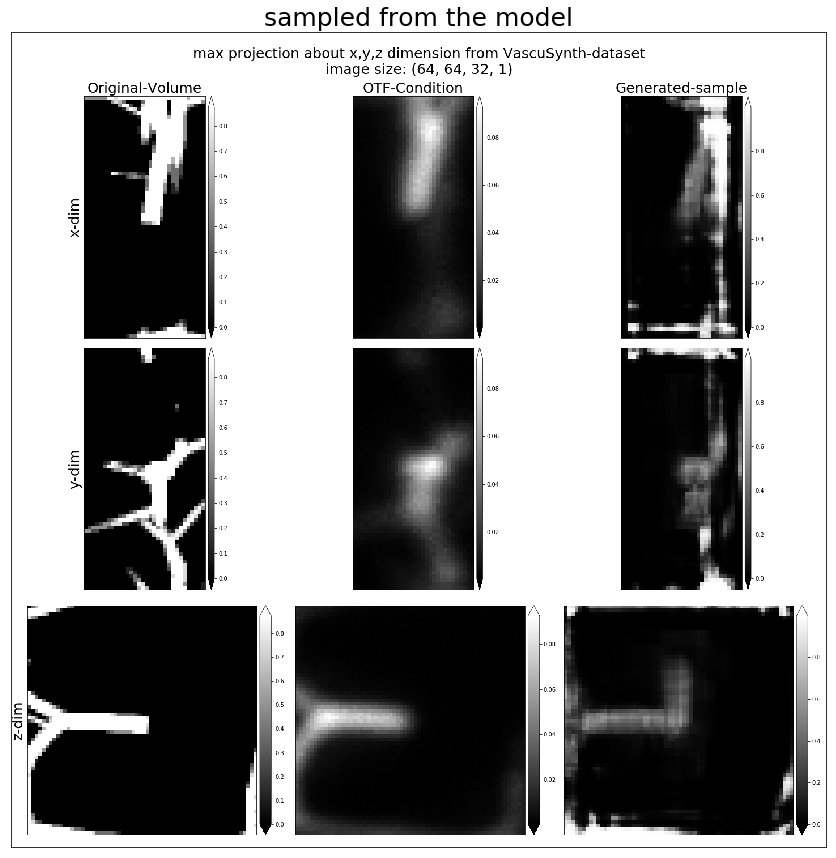

In [24]:
volumes = glob(last_model[0]+'/*')
volumes = np.random.choice(volumes, size=1)[0]
vol_plot = io.imread(volumes)

print('plotted volume:', volumes)
f = plt.figure(figsize=(15,15))
plt.imshow(vol_plot); plt.xticks([]); plt.yticks([]); plt.title('sampled from the model', fontsize=25);

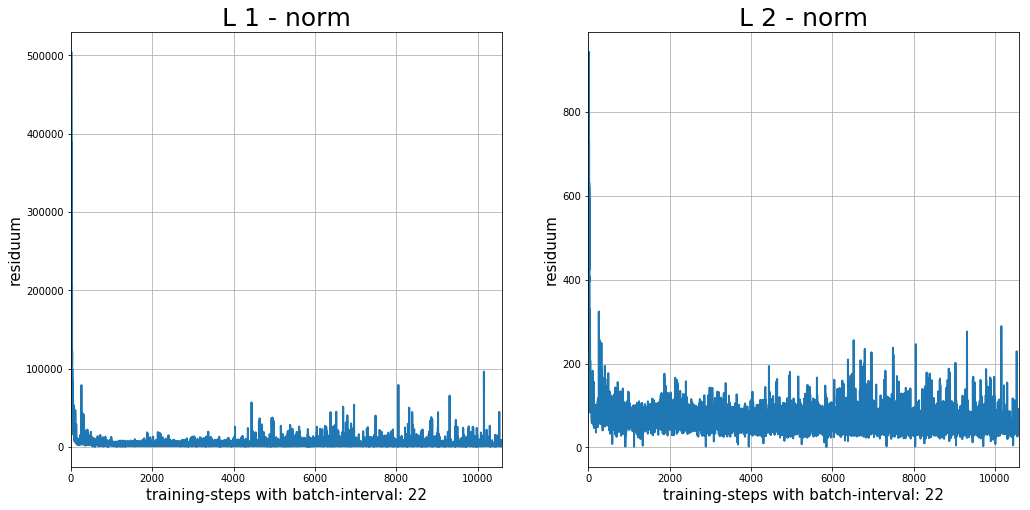

In [25]:
csv_file = '{0}/{1}.csv'.format(last_model[0], max_date)
df = pd.read_csv(csv_file)

f = plt.figure(figsize=(17,8))
plt.subplot(121); df['L_1'].plot(linewidth=2); plt.grid(True); 
plt.title('L 1 - norm', fontsize=25); plt.ylabel('residuum', fontsize=15);
plt.xlabel('training-steps with batch-interval: {}'.format(s_interval), fontsize=15)
plt.subplot(122); df['L_2'].plot(linewidth=2); plt.grid(True); 
plt.title('L 2 - norm', fontsize=25); plt.ylabel('residuum', fontsize=15);
plt.xlabel('training-steps with batch-interval: {}'.format(s_interval), fontsize=15)
plt.show()

In [125]:
# (1) Two lists of numbers
x1 = [1, 2, 3, 5, 6]
y1 = [1, 4.5, 7, 24, 38]

# (2) Make dictionary linking x and y coordinate lists to 'x' and 'y' keys
trace1 = dict(x=x1, y=y1)

# (3) Make list of 1 trace, to be sent to Plotly
data = [trace1]
py.plot(data, filename='s0_first_plot')

Aw, snap! We didn't get a username with your request.

Don't have an account? https://plot.ly/api_signup

Questions? accounts@plot.ly


''

### validate trained model on other volume-images

In [58]:
_, generator = hp.model_loader('2018_10_8', '15_03_19_gene_10%')

Loaded model from disk


In [34]:
### TEST
from keras.models import model_from_yaml

# load YAML and create model
yaml_file = open('model_G.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
generator = model_from_yaml(loaded_model_yaml)
# load weights into new model
generator.load_weights("G.h5")
print("Loaded model from disk")

Loaded model from disk


../data/3D/VALIDATION/dub\dub40.tif
original shape	 (768, 512, 33)
cutted shape	 (64, 64, 32)
resized shape	 (64, 64, 64)


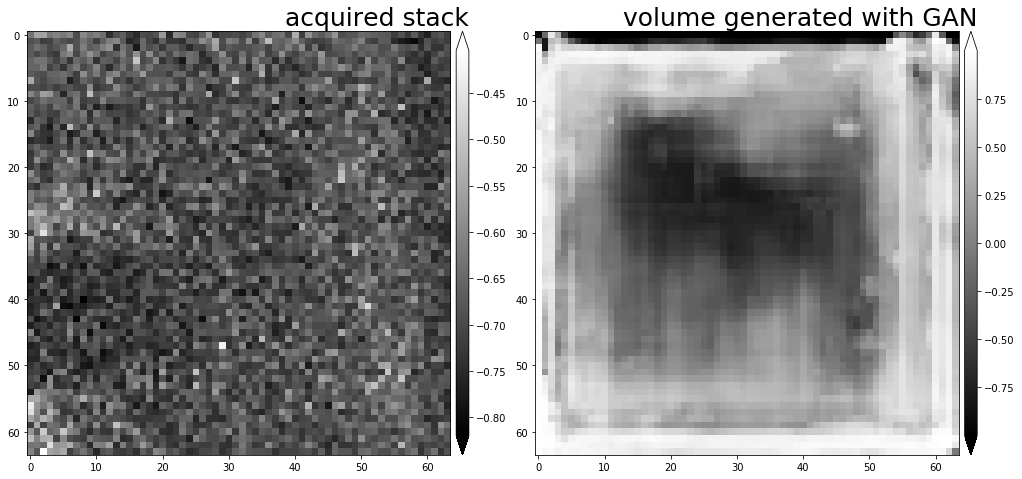

Wall time: 1.15 s


In [44]:
%%time

# v_path = np.random.choice(glob('../data/3D/\VascuSynth/test/*'), size=1)[0]; print(v_path)
v_path = np.random.choice(glob('./data/3D/VALIDATION/dub/*'), size=1)[0]                          
# v_path = ''../data/3D/VALIDATION/dub/dub12.tif'
# v_path = '../data/3D/VALIDATION/HEART/HEART.tif'
# v_path = '../data/3D/VALIDATION/synchrotron_acquisitions_neuroblastoma_cells/example04.tif'
print(v_path)

vol_validation = np.swapaxes(io.imread(v_path), 0, 2)
vol_validation = vol_validation/127.5 - 1.
print('original shape\t', vol_validation.shape)

vol_validation = gan.data_loader.cut_volume(vol_validation, (64,64,32), centered=False)
print('cutted shape\t', vol_validation.shape)

vol_validation = np.pad(vol_validation, pad_width=((0,0),(0,0),(0,32)), mode='reflect')
# from skimage.transform import resize
# vol_validation = resize(vol_validation, output_shape=(64,64,16))
print('resized shape\t', vol_validation.shape)

vol_validation = np.expand_dims(vol_validation, axis=4)
vol_validation = np.expand_dims(vol_validation, axis=0)
vol_validation_gan = generator.predict(vol_validation).squeeze()
# vol_validation_gan = generator.predict(vol_validation).squeeze()

f = plt.figure(figsize=(15,10))
plt.subplot(121); 
temp = plt.imshow(np.max(vol_validation.squeeze(), axis=2), cmap='gray'); 
hp.colorbar(temp); plt.xticks([]); plt.yticks([]); plt.title('acquired stack', fontsize=25, loc='right');
plt.subplot(122); 
temp = plt.imshow(np.max(vol_validation_gan, axis=2), cmap='gray'); 
hp.colorbar(temp); plt.xticks([]); plt.yticks([]); plt.title('volume generated with GAN', fontsize=25, loc='right')
plt.subplots_adjust(left=0.02, wspace=0.15, top=0.92)
plt.show()

../data/3D/VALIDATION/dub\dub12.tif
original shape	 (768, 512, 33)
cutted shape	 (64, 64, 32)
resized shape	 (64, 64, 64)


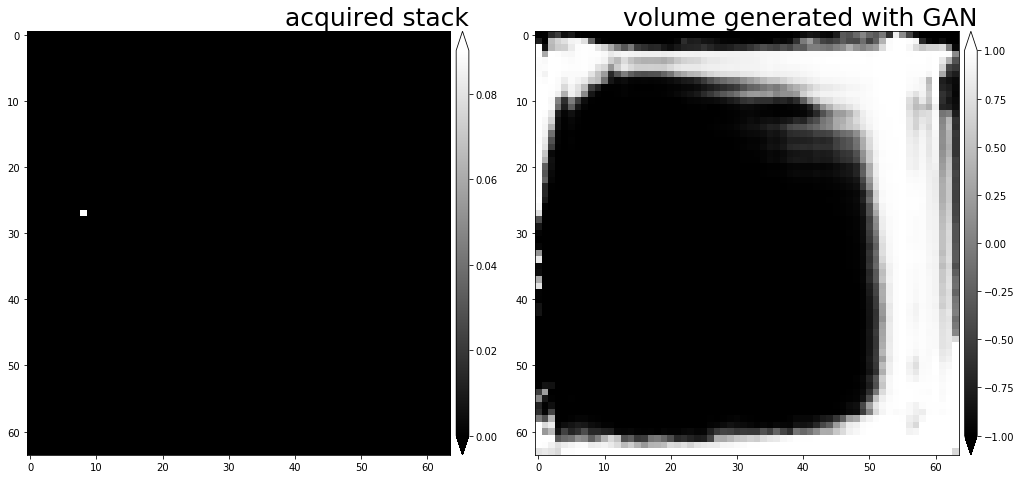

Wall time: 1.41 s


In [39]:
%%time

# v_path = np.random.choice(glob('../data/3D/\VascuSynth/test/*'), size=1)[0]; print(v_path)
v_path = np.random.choice(glob('./data/3D/VALIDATION/dub/*'), size=1)[0]                          
# v_path = ''../data/3D/VALIDATION/dub/dub12.tif'
# v_path = '../data/3D/VALIDATION/HEART/HEART.tif'
# v_path = '../data/3D/VALIDATION/synchrotron_acquisitions_neuroblastoma_cells/example04.tif'
print(v_path)

vol_validation = np.swapaxes(io.imread(v_path), 0, 2)
vol_validation = vol_validation/127.5 - 1.
print('original shape\t', vol_validation.shape)

vol_validation = gan.data_loader.cut_volume(vol_validation, (64,64,32), centered=False)
print('cutted shape\t', vol_validation.shape)

vol_validation = np.pad(vol_validation, pad_width=((0,0),(0,0),(0,32)), mode='constant')
# from skimage.transform import resize
# vol_validation = resize(vol_validation, output_shape=(64,64,16))
print('resized shape\t', vol_validation.shape)

vol_validation = np.expand_dims(vol_validation, axis=4)
vol_validation = np.expand_dims(vol_validation, axis=0)
vol_validation_gan = gan.generator.predict(vol_validation).squeeze()
# vol_validation_gan = generator.predict(vol_validation).squeeze()

f = plt.figure(figsize=(15,10))
plt.subplot(121); 
temp = plt.imshow(np.max(vol_validation.squeeze(), axis=2), cmap='gray'); 
hp.colorbar(temp); plt.xticks([]); plt.yticks([]); plt.title('acquired stack', fontsize=25, loc='right');
plt.subplot(122); 
temp = plt.imshow(np.max(vol_validation_gan, axis=2), cmap='gray'); 
hp.colorbar(temp); plt.xticks([]); plt.yticks([]); plt.title('volume generated with GAN', fontsize=25, loc='right')
plt.subplots_adjust(left=0.02, wspace=0.15, top=0.92)
plt.show()

### save/load models, gradients and parameters

In [ ]:
save_models = True
temp = {"hyper_parameter": gan.settings, "OTF": gan.OTF_info}

if save_models:
    hp.model_saver(model_instance=gan.discriminator, model_name='disc', hparam=temp)
    hp.model_saver(model_instance=gan.generator, model_name='gene', hparam=temp)
    hp.model_saver(model_instance=gan.combined, model_name='combined', hparam=temp)

In [ ]:
load_models = False

if load_models:
    disc_json, disc = hp.model_loader('2018_8_1', '10_44_00_disc_10%')

In [41]:
# skimage.filters.wiener